# Check QKernel Transpilation

When we submit a qkernel instance we can leave the transpilation to the optimization process in the sampler or we can submit a pretranspiled ftmap. However since the kernel is the composition of the featuremap and its transpose we would like to check if the final circuit, to run on the Quantum device, is further transpiled when we use a already transpiled ft map.
To check this we compare the following circuits:

* $ftmap_{transposed} +(ftmap_{transposed})^T$
* Qkernel as its handled by the FidelityQuantumKernel instance when we submit a transpiled ft map.

In [1]:
#import qiskit libraries
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import *
# Importing standard Qiskit libraries and configuring account
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Batch
import qiskit_ibm_runtime 
#Load feature maps
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.state_fidelities import ComputeUncompute
from Kernels.src.ComputeUncompute_2 import ComputeUncompute_2
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_machine_learning.kernels import FidelityQuantumKernel


In [2]:
#Load account and select backend
service=QiskitRuntimeService(channel="ibm_quantum",
                             token="95e70510a429e03c7cc4ce4c5c979c794135dbacffbebe5325dcd8b627cfe42c9f61e91945ba1adea992f81849c74cc5e0ed1ab93977db5084dd26a28fd25dd8")
#Get example backend
backend = service.get_backend("ibmq_mumbai")
target = backend.target
coupling_map = target.build_coupling_map()


## Build ftmaps

In [3]:
import qiskit.qasm3
#cqcarbhaaam0008n844g
zz_full = """
OPENQASM 3.0;
include "stdgates.inc";
input float[64] _x_0_;
input float[64] _x_1_;
input float[64] _x_2_;
input float[64] _x_3_;
input float[64] _y_0_;
input float[64] _y_1_;
input float[64] _y_2_;
input float[64] _y_3_;
bit[4] _measure;
h $0;
p(2.0*_x_0_) $0;
h $1;
p(2.0*_x_1_) $1;
cx $0, $1;
p(2.0*(pi - _x_0_)*(pi - _x_1_)) $1;
cx $0, $1;
h $2;
p(2.0*_x_3_) $2;
h $4;
p(2.0*_x_2_) $4;
swap $4, $1;
cx $0, $1;
p(2.0*(pi - _x_0_)*(pi - _x_2_)) $1;
cx $0, $1;
cx $4, $1;
p(2.0*(pi - _x_1_)*(pi - _x_2_)) $1;
cx $4, $1;
swap $2, $1;
cx $0, $1;
p(2.0*(pi - _x_0_)*(pi - _x_3_)) $1;
cx $0, $1;
cx $4, $1;
p(2.0*(pi - _x_1_)*(pi - _x_3_)) $1;
cx $4, $1;
cx $2, $1;
p(2.0*(pi - _x_2_)*(pi - _x_3_)) $1;
cx $2, $1;
cx $2, $1;
p(-2.0*(pi - _y_2_)*(pi - _y_3_)) $1;
cx $2, $1;
cx $4, $1;
p(-2.0*(pi - _y_1_)*(pi - _y_3_)) $1;
cx $4, $1;
cx $0, $1;
p(-2.0*(pi - _y_0_)*(pi - _y_3_)) $1;
cx $0, $1;
swap $2, $1;
cx $4, $1;
p(-2.0*(pi - _y_1_)*(pi - _y_2_)) $1;
cx $4, $1;
cx $0, $1;
p(-2.0*(pi - _y_0_)*(pi - _y_2_)) $1;
cx $0, $1;
swap $4, $1;
p(-2.0*_y_2_) $4;
h $4;
p(-2.0*_y_3_) $2;
h $2;
cx $0, $1;
p(-2.0*(pi - _y_0_)*(pi - _y_1_)) $1;
cx $0, $1;
p(-2.0*_y_1_) $1;
h $1;
p(-2.0*_y_0_) $0;
h $0;
barrier $0, $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13, $14, $15, $16, $17, $18, $19, $20, $21, $22, $23, $24, $25, $26;
_measure[0] = measure $0;
_measure[1] = measure $1;
_measure[2] = measure $2;
_measure[3] = measure $4;

"""
circuit_zz_full = qiskit.qasm3.loads(zz_full)

In [5]:
#cqd0jgtgtagg008qnnb0
z= """
OPENQASM 3.0;
include "stdgates.inc";
input float[64] _x_0_;
input float[64] _x_1_;
input float[64] _x_2_;
input float[64] _x_3_;
input float[64] _y_0_;
input float[64] _y_1_;
input float[64] _y_2_;
input float[64] _y_3_;
bit[4] _measure;
h $0;
p(2.0*_x_0_) $0;
h $1;
p(2.0*_x_1_) $1;
h $2;
p(2.0*_x_3_) $2;
h $4;
p(2.0*_x_2_) $4;
p(-2.0*_y_2_) $4;
h $4;
p(-2.0*_y_3_) $2;
h $2;
p(-2.0*_y_1_) $1;
h $1;
p(-2.0*_y_0_) $0;
h $0;
barrier $0, $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13, $14, $15, $16, $17, $18, $19, $20, $21, $22, $23, $24, $25, $26;
_measure[0] = measure $0;
_measure[1] = measure $1;
_measure[2] = measure $2;
_measure[3] = measure $4;

"""
circuit_z = qiskit.qasm3.loads(z)

In [6]:
import qiskit.qasm3

zz_linear = """
OPENQASM 3.0;
include "stdgates.inc";
input float[64] _x_0_;
input float[64] _x_1_;
input float[64] _x_2_;
input float[64] _x_3_;
input float[64] _y_0_;
input float[64] _y_1_;
input float[64] _y_2_;
input float[64] _y_3_;
bit[4] _measure;
rz(pi/2) $0;
sx $0;
rz(pi/2) $0;
rz(2.0*_x_0_) $0;
rz(pi/2) $1;
sx $1;
rz(pi/2) $1;
rz(2.0*_x_1_) $1;
cx $0, $1;
rz(2.0*(pi - _x_0_)*(pi - _x_1_)) $1;
cx $0, $1;
rz(pi/2) $2;
sx $2;
rz(pi/2) $2;
rz(2.0*_x_3_) $2;
rz(pi/2) $4;
sx $4;
rz(pi/2) $4;
rz(2.0*_x_2_) $4;
cx $4, $1;
cx $1, $4;
cx $4, $1;
cx $0, $1;
rz(2.0*(pi - _x_0_)*(pi - _x_2_)) $1;
cx $0, $1;
cx $4, $1;
rz(2.0*(pi - _x_1_)*(pi - _x_2_)) $1;
cx $4, $1;
cx $2, $1;
cx $1, $2;
cx $2, $1;
cx $0, $1;
rz(2.0*(pi - _x_0_)*(pi - _x_3_)) $1;
cx $0, $1;
cx $4, $1;
rz(2.0*(pi - _x_1_)*(pi - _x_3_)) $1;
cx $4, $1;
cx $2, $1;
rz(2.0*(pi - _x_2_)*(pi - _x_3_)) $1;
rz(-2.0*(pi - _y_2_)*(pi - _y_3_)) $1;
cx $2, $1;
cx $4, $1;
rz(-2.0*(pi - _y_1_)*(pi - _y_3_)) $1;
cx $4, $1;
cx $0, $1;
rz(-2.0*(pi - _y_0_)*(pi - _y_3_)) $1;
cx $0, $1;
rz(-2.0*_y_3_) $1;
rz(pi/2) $1;
sx $1;
rz(pi/2) $1;
cx $2, $1;
cx $1, $2;
cx $2, $1;
cx $4, $1;
rz(-2.0*(pi - _y_1_)*(pi - _y_2_)) $1;
cx $4, $1;
cx $0, $1;
rz(-2.0*(pi - _y_0_)*(pi - _y_2_)) $1;
cx $0, $1;
rz(-2.0*_y_2_) $1;
rz(pi/2) $1;
sx $1;
rz(pi/2) $1;
cx $4, $1;
cx $1, $4;
cx $4, $1;
cx $0, $1;
rz(-2.0*(pi - _y_0_)*(pi - _y_1_)) $1;
cx $0, $1;
rz(-2.0*_y_0_) $0;
rz(pi/2) $0;
sx $0;
rz(pi/2) $0;
rz(-2.0*_y_1_) $1;
rz(pi/2) $1;
sx $1;
rz(pi/2) $1;
barrier $0, $1, $4, $2;
_measure[0] = measure $0;
_measure[1] = measure $1;
_measure[2] = measure $4;
_measure[3] = measure $2;

"""
circuit_zz_linear = qiskit.qasm3.loads(zz_linear)

In [8]:
#Compare the two circuits
print('circuit zz_full depth:',circuit_zz_full.depth())
print('Gate counts circuit 1:', circuit_zz_full.count_ops())
print('circuit z depth:',circuit_z.depth())
print('Gate counts circuit z:', circuit_z.count_ops())
print('circuit zz_linear depth:',circuit_zz_linear.depth())
print('Gate counts circuit zz_linear:', circuit_zz_linear.count_ops())


circuit zz_full depth: 45
Gate counts circuit 1: OrderedDict([('cx', 24), ('p', 20), ('h', 8), ('swap', 4), ('measure', 4), ('barrier', 1)])
circuit z depth: 5
Gate counts circuit z: OrderedDict([('h', 8), ('p', 8), ('measure', 4), ('barrier', 1)])
circuit zz_linear depth: 63
Gate counts circuit zz_linear: OrderedDict([('rz', 36), ('cx', 34), ('sx', 8), ('measure', 4), ('barrier', 1)])


/CTGlab/home/valeria/miniconda3/envs/qiskit-buona/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


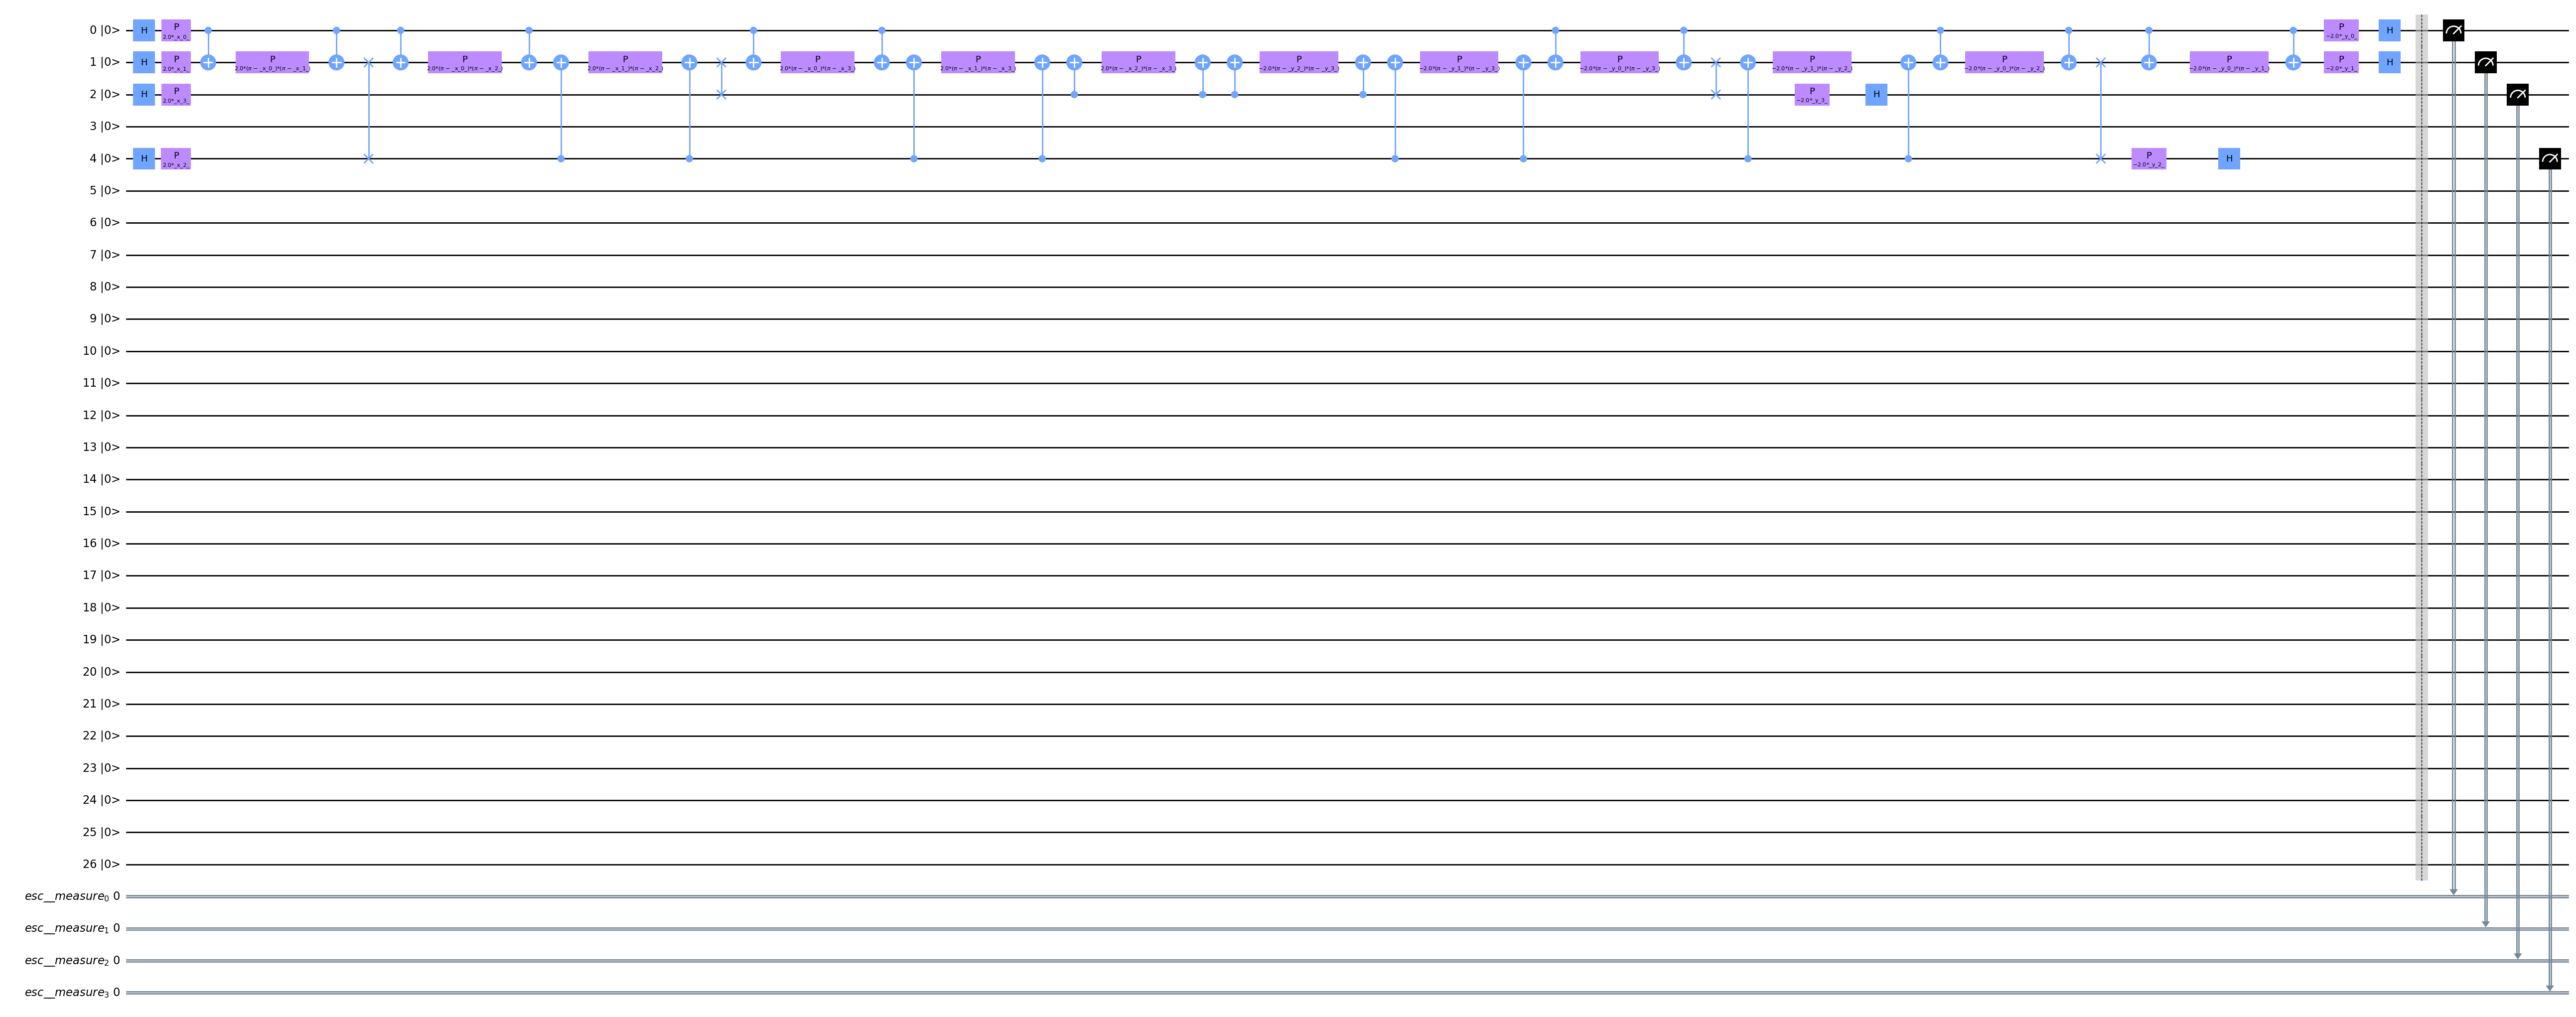

In [10]:
circuit_zz_full.draw(output='mpl',cregbundle=False,fold=-1,initial_state=True)